In [1]:
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
--image_name='people2.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net:get(1))

_,classes = net:forward(I:cuda()):view(-1):float():sort(true)

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


==> Loading synsets	


==> Loading image and imagenet mean	


==> Preprocessing	


predicted class 1: 	goldfish, Carassius auratus	
predicted class 2: 	macaw	
predicted class 3: 	flamingo	
predicted class 4: 	axolotl, mud puppy, Ambystoma mexicanum	
predicted class 5: 	eft	


cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



   1
 384
  13
  13
[torch.LongStorage of size 4]



==> Time elapsed: 0.19872307777405 seconds	


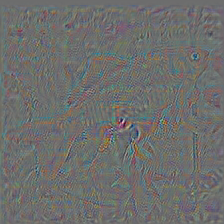

In [3]:
require'testing_deconvLayer'

-- set deconvNet
local deconvNet = nn.Sequential()

deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(net:get(1):get(13).output)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)

In [9]:
-- conv1_fm = net:get(1):get(1).output
-- deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), false )
-- vis_c1 = deconv1:forward(conv1_fm)
-- itorch.image(vis_c1)

cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



   1
   3
 224
 224
[torch.LongStorage of size 4]



cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



   1
   3
 224
 224
[torch.LongStorage of size 4]



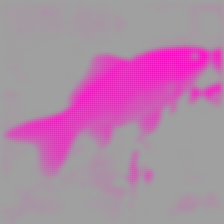

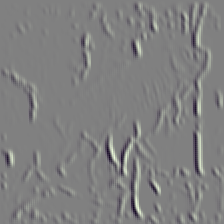

In [4]:
conv1_fm = net:get(1):get(1).output
deconv1 = Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), 47 )
vis_1 = deconv1:forward(conv1_fm)

deconv1 = Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), 94 )
vis_2 = deconv1:forward(conv1_fm)

itorch.image(vis_1)
itorch.image(vis_2)

cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



   1
   3
 224
 224
[torch.LongStorage of size 4]

==> Time elapsed: 0.181401014328 seconds	


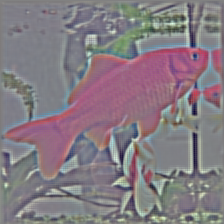

In [9]:
conv1_fm = net:get(1):get(1).output
deconv_idx = torch.IntTensor(96)
--deconv_idx[1] = 47
--deconv_idx[2] = 94

for i=1,96 do
   deconv_idx[i]=i 
end
    
deconv1 = Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), deconv_idx  )
deconv_timer = torch.Timer()
vis_n = deconv1:forward(conv1_fm)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_n)


 256
  26
  26
[torch.LongStorage of size 3]



cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



  1
 96
 55
 55
[torch.LongStorage of size 4]



==> Time elapsed: 0.53701901435852 seconds	


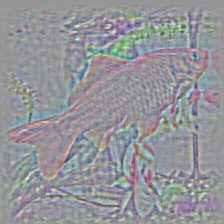

In [8]:
conv2_fm = net:get(1):get(5).output
print(conv2_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end

deconv2 = nn.Sequential()
deconv2:add(Test_SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), deconv_idx ))
deconv2:add(unpooling_layers[1])
deconv2:add(cudnn.ReLU(true))
deconv2:add(Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))


deconv_timer = torch.Timer()
vis_c2 = deconv2:forward(conv2_fm)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c2)


 384
  13
  13
[torch.LongStorage of size 3]



cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



   1
 256
  13
  13
[torch.LongStorage of size 4]



==> Time elapsed: 0.45119094848633 seconds	


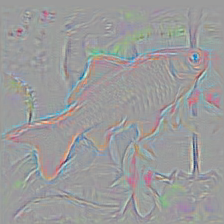

In [11]:
conv3_fm = net:get(1):get(9).output
print(conv3_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end

deconv3 = nn.Sequential()

deconv3:add(Test_SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), deconv_idx ))
deconv3:add(unpooling_layers[2])
deconv3:add(cudnn.ReLU(true))
deconv3:add(Test_SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv3:add(unpooling_layers[1])
deconv3:add(cudnn.ReLU(true))
deconv3:add(Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))
deconv_timer = torch.Timer()
vis_c3 = deconv3:forward(conv3_fm)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c3)


 384
  13
  13
[torch.LongStorage of size 3]



cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



   1
 384
  13
  13
[torch.LongStorage of size 4]



==> Time elapsed: 0.38495302200317 seconds	


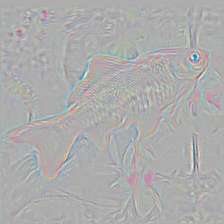

In [12]:
conv4_fm = net:get(1):get(11).output
print(conv4_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end


deconv4 = nn.Sequential()

deconv4:add(Test_SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), deconv_idx ))
deconv4:add(cudnn.ReLU(true))
deconv4:add(Test_SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconv4:add(unpooling_layers[2])
deconv4:add(cudnn.ReLU(true))
deconv4:add(Test_SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv4:add(unpooling_layers[1])
deconv4:add(cudnn.ReLU(true))
deconv4:add(Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))
deconv_timer = torch.Timer()
vis_c4 = deconv4:forward(conv4_fm)
print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c4)


 256
  13
  13
[torch.LongStorage of size 3]



cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	



   1
 384
  13
  13
[torch.LongStorage of size 4]



==> Time elapsed: 0.3178379535675 seconds	


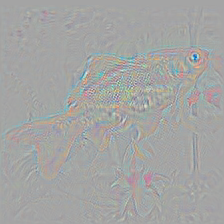

In [13]:
conv5_fm = net:get(1):get(13).output
print(conv5_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end




deconvNet = nn.Sequential()

deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), deconv_idx ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)

cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	


==> Time elapsed: 0.21016407012939 seconds	


0	


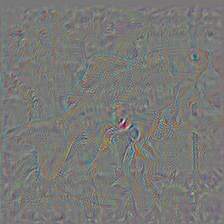

==> Time elapsed: 0.12574315071106 seconds	


0	


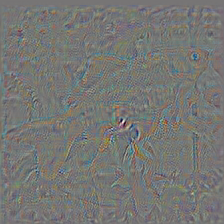

==> Time elapsed: 0.1291880607605 seconds	


0	


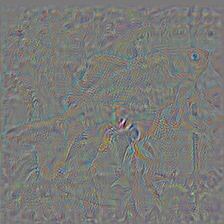

==> Time elapsed: 0.12297010421753 seconds	


0	


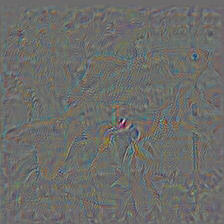

==> Time elapsed: 0.11956810951233 seconds	


0	


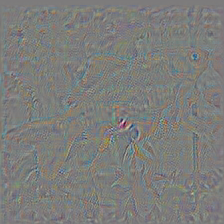

==> Time elapsed: 0.12120795249939 seconds	


0	


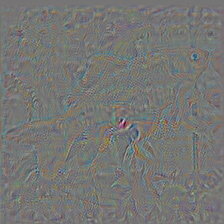

==> Time elapsed: 0.12375402450562 seconds	


0	


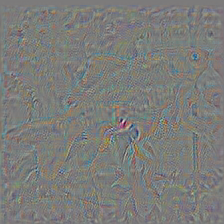

==> Time elapsed: 0.12614512443542 seconds	


0	


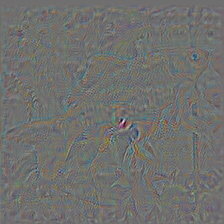

==> Time elapsed: 0.12719917297363 seconds	


0	


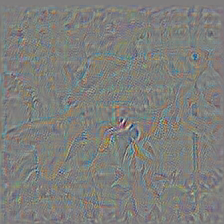

==> Time elapsed: 0.1303288936615 seconds	


0	


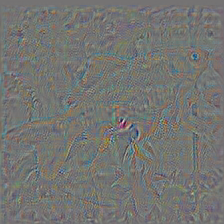

==> Time elapsed: 0.15926194190979 seconds	


0	


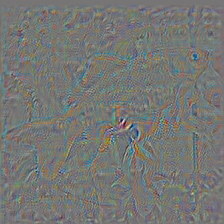

==> Time elapsed: 0.12608408927917 seconds	


0	


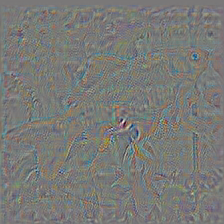

==> Time elapsed: 0.13297080993652 seconds	


0	


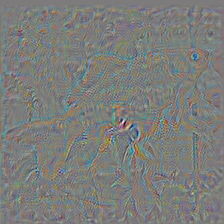

==> Time elapsed: 0.12974905967712 seconds	


0	


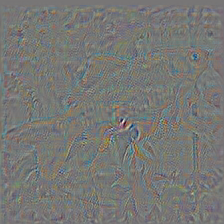

==> Time elapsed: 0.12302899360657 seconds	


0	


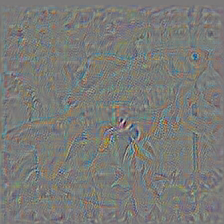

==> Time elapsed: 0.12773203849792 seconds	


0	


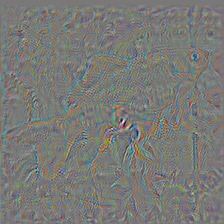

==> Time elapsed: 0.1211040019989 seconds	


0	


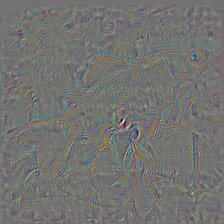

==> Time elapsed: 0.11696314811707 seconds	


0	


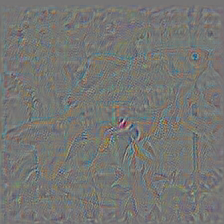

==> Time elapsed: 0.11909008026123 seconds	


0	


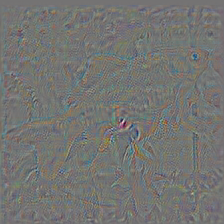

==> Time elapsed: 0.12001609802246 seconds	


0	


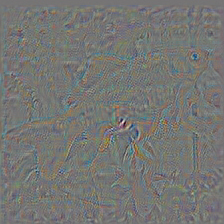

In [7]:
deconvNet = nn.Sequential()

deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(Test_SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))


layer_n = 1
deconv_timer = torch.Timer()

for i=1,20 do
    deconv_timer = torch.Timer()
    vis_c5 = deconvNet:forward(net:get(1):get(13).output)

    print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')  
    --print( deconvNet_test2:get(layer_n).output:size() )
    
    if i==1 then
        last_output = deconvNet:get(layer_n).output
        --last_output = net:get(1):get(13).output
    end
    
    error_tensor = last_output - deconvNet:get(layer_n).output
    --error_tensor = last_output-net:get(1):get(13).output
    local test_error = 0
    for j=1, error_tensor:view(-1):size(1) do
        test_error = test_error + error_tensor:view(-1)[j]
    end
        
    print(test_error)

    --itorch.image( deconvNet:get(1).output )
    itorch.image(vis_c5 )
    last_time = deconv_timer:time().real
end

